# Thermodynamics Workbook
created by Gavin Woolman 
https://gitlab.com/GWoolman

May be used free of charge. Selling without prior written consent prohibited. In all cases this notice must remain intact.

<h1 style="font-size: 50px">How to use Jupyter Notebooks</h1>







### Jupyter notebooks are great. 

They have blocks of text called "cells", which either have chunks of code, or chunks of text. 

To run a 'cell', simply click on the cell so it is highlighted, then click "run" at the top menu, or press "SHIFT+ENTER"

When you run a cell, any objects or variables defined in that cell are remembered by the notebook's computational engine, called a "Kernel". 

In later parts of this workbook, some cells will redefine objects. If you go back to an earlier part of the notebook, just make sure to rerun the initial cells of that part to make sure the Kernel has the correct definitions. 

To give it a go, try running the cell below...

In [9]:
print("Yay! You ran a cell! Now you're ready for the rest of the notebook")

Yay! You ran a cell! Now you're ready for the rest of the notebook


# Run this cell, but feel free to ignore what it does. It only imports things.

In [10]:
import numpy as np
from timeit import default_timer as timer
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.interpolate import UnivariateSpline

from ipywidgets import IntProgress
from IPython.display import display

SMALL_SIZE = 13
MEDIUM_SIZE = 15
BIGGER_SIZE = 17

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams["savefig.bbox"] = 'tight'

# Constants
Boltzmann_Constant = 8.617333262e-5 # eV / K / mol

print('Finished importing things')

Finished importing things


<h1 style="font-size: 50px">Thermodynamics Workshop</h1>

## Motivation:
This workshop is designed to show how different models of the Gibbs Free Energy can lead to different and interesting phase diagrams.

## How to use this notebook
Each part introduces new ways of writing the Gibbs free energy, then plotting the resulting phase diagrams. 

Go through each section, then try and answer the questions at the end. 

Feel free to play around with any of the parameters defined in the 'Gibbs_Free_Energy' function, to see how it changes the final calculated $P$-$T$ phase diagram. 


## Structure of this workbook
Each part begins with an equation for the Gibbs free energy named *Gibbs_Free_Energy*

This is where you should edit the parameters which define the Gibbs free energy.

Then there is a function for minimizing the Gibbs_Free_Energy for a set pressure $P$ and temperature $T$. This function probably doesn't need changing. 

Then there are functions to plot different thermodynamic functions over pressure and temperature.  

Finally, at the end of each part, questions & challenges are presented. 
Harder questions are marked with a &clubs;

<h1 style="font-size: 50px">Part 0: Under the hood</h1>



# Minimizing the Free Energy

The function 'minimize_Free_Energy' is designed as a general function for finding the set of variables which minimize the Free Energy --- subject to some constraints. 

Sometimes it is possible to write the free energy as a macroscopic function of multiple thermodynamic variables: for example, volume, pressure, and temperature. 

In any particular experiment, some of these variables are in equilibrium with the surrounding environment, and others are not. The variables which are in equilibrium are effectively 'fixed', while the others are allowed to fluctuate. 

For example, a sample loaded into a diamond anvil cell and given plenty of time to relax will probably be in thermal equilibrium with the environment, have a fixed number of atoms in the sample chamber, and held at a constant pressure. This would be called the "$NPT$ ensemble", because the number $N$ of atoms, the pressure $P$, and the temperature $T$ are the three thermodynamic variables are in equilibrium with the environment, and effectively fixed. 

Suppose the free energy for this system can be written as a function of $N$, $P$, $T$, and also volume $V$. The volume $V$ which the system will most likely adopt will be the one which minimizes the free energy at fixed $N$, $P$, and $T$ (we call this ensemble the 'Gibbs' free energy). 

$$ \underbrace{\text{min}}_{V}\left[~~G_{NPT}(V)~~\right]  =  \underbrace{\text{min}}_{V}\left[~~E_{NPT}(V) - TS_{NPT}(V) + PV~~\right]  $$

The function 'minimize_Free_Energy' is designed to be a flexible function for minimizing any form of the free energy $G$, with some parameters (e.g. pressure) held fixed, while others (e.g. volume) are allowed to vary. 

The function repeats the minimization several times with different initial values, just to make sure it is finding the *global* minimum of the free energy, and not a local minimum. 



In [11]:
from itertools import product

def minimize_Free_Energy( fixed_parameters , initial_values_list, bounds_list=None, constraints=()):
    """
    Repeats the minimization of G for some fixed parameters. 
    
    arguments:
        fixed_parameters (e.g. temperature and pressure) 
                    the fixed macroscopic parameters that are in equilibrium with the environment. 
        
        initial_values_list  , [N_variables list of [N_starting_values] lists] 
                                list of lists containing all the starting values for all the variables to minimize the 
                                Gibbs free energy with respect to. e.g. [(x1, x2, x3),(V1,V2,V3)] will start the minimization
                                from (x1,V1), (x1,V2), (x1,V3),...,(x3,V3) 
        
        bounds_list           , [N_variables list of (lower_bound, upper_bound)] list of boundary tuples. 
    

    Returns the minimized Gibbs Free Energy object, which contains G and the parameters which gave it. 
    """    
    if bounds_list == None:
        print('Warning --- no bounds given for any variables!')
    
    G_min_solutions = []
    G_min_values    = []
    for initial_values in product( *initial_values_list ):
        solution = minimize(Gibbs_Free_Energy , 
                            initial_values,
                            args=fixed_parameters,
                            tol=1e-8,
                            bounds=bounds_list,
                            constraints=constraints)
        G_min_solutions.append( solution )
        G_min_values.append( solution.fun )
    return G_min_solutions[ np.argmin(G_min_values) ]

print('Function defined successfully!')  

Function defined successfully!


# Calculating 2 parameter Phase Diagram

This function is to calculate a 2-parameter phase diagram. It returns a 2D matrix of minimized free energies, and variables which minimize them. This can then be used to make a contour plot. 

In [12]:
def calculate_2_parameter_phase_diagram(x_parameters, 
                               y_parameters , 
                               initial_values_list, 
                               bounds_list=None, 
                               constraints=()):
    """
    arguments:
        x_parameters and y_parameters (e.g. list_of_temperatures , list_of_pressures ), 
                                the phase-space over which to calculate the 2D phase_diagram
        
        initial_values_list  , [N_variables list of [N_starting_values] lists] 
                                lists of lists containing all the starting values for all the variables to minimize the 
                                Gibbs free energy with respect to. e.g. [(x1, x2, x3),(V1,V2,V3)] will start the minimization
                                from (x1,V1), (x1,V2), (x1,V3),...,(x3,V3) 
        
        bounds_list           , [N_variables list of (lower_bound, upper_bound)] list of boundary tuples. 
        
        
    returns:
        (N_x , N_y , N_variables+1) array
        where [:,:,0] is the minimized free energy at each x,y
        and [:,:,1:] are the variables which the free energy was minimized with respect to. 
    """
    
    max_count = len(x_parameters) * len(y_parameters)
       
    num_variables = len( initial_values_list )
    
    # --- Makes a progress bar to track calculation of the phase diagram
    fbar = IntProgress(min=0,max=max_count)
    display(fbar)
    # ---
    
    Free_Energy_min_array = np.empty( ( len(y_parameters) , len(x_parameters) , num_variables+1 ) )
    
    # Do the calculation
    start = timer()
    #G_min_solutions = []
    counter=0
    for i,y in enumerate(y_parameters):
        for j,x in enumerate(x_parameters):
            
            
            Free_Energy_min_solution = minimize_Free_Energy([y,x],
                                                            initial_values_list=initial_values_list , 
                                                            bounds_list=bounds_list,
                                                            constraints=constraints)
            
            #G_min_solutions.append( solutions )
            fbar.value += 1  # increments progress bar
            
            counter+=1
            
            # fill in the array of G and G_min_variables
            Free_Energy_min_array[i,j,0]   = Free_Energy_min_solution.fun
            for k in range(num_variables): 
                Free_Energy_min_array[i,j,1+k] = Free_Energy_min_solution.x[k]
        if counter > 0:
            print("Estimated time to completion: {:.0f} s                            ".format( (timer() - start) / counter * (max_count - counter) ),  end='\r' )
            
    # Reshape the Free_Energy_min_array to be more convenient
    Free_Energy_min_array = np.transpose(Free_Energy_min_array, axes=(2,0,1))
    
    print('Finished successfully!                                                                 ')
    return Free_Energy_min_array
print('Defined function successfully')

Defined function successfully


<h1 style="font-size: 50px">Part 1: Solid-liquid melting</h1>

# Gibbs free energy
The state of a substance in thermal equilibrium is the state that minimizes the Gibbs Free Energy. 

We begin with a simple two-state model, in which the atoms can form one of two states, A or B.


We define the fraction of atoms in state A as
$$ x = \frac{N_A}{N_{TOT}} $$

In this initial simple model, the total Gibbs free energy is given as a linear combination of free energies from the two different states, solid and liquid, which have different free energies.

The liquid has a higher energy $U$ than the solid, but it also has a slightly higher entropy $S$, and it has a different equilibrium volume $V$. Thus, there are three key parameters to this model:
    
$~~~~~ \Delta U$ , representing the energy difference,
    
$~~~~~\Delta S$ , representing the entropy difference, and
    
$~~~~~\Delta V$ , representing a difference in preferred volumes between the two phases. 

The code below calculates the total Gibbs energy for a given fraction of solid to liquid, 
$$\gamma = \frac{N_{solid}}{N_{solid} + N_{liquid}}$$

$$ G_{total} = \gamma G_{solid} + (1-\gamma)G_{liquid} $$
$$ ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ = \gamma\left[0.0\right] + (1-\gamma)\left[\Delta U + P\Delta V - T\Delta S\right]$$

So $\gamma = 1$ corresponds to a full solid, $\gamma = 0$ corresponds to full melting, and $0<\gamma < 1$ is something in between.

# Gibbs Free Energy: edit the settings delta_U , delta_S, and delta_V!

In [61]:
def Gibbs_Free_Energy(variables , args):
    """
    Calculates the Gibbs Free Energy for a given fraction x of atoms in state 'A' relative to total system
    
    arguments:
        variables : 
            gamma , the fraction melted
            V     , the volume of the system
    
        args , a list of other arguments. 
                at the moment, just temperature and pressure, but add more as needed
        
        settings : where delta_U , delta_S, and delta_V are set
        
    returns:
        Gibbs Free Energy for the specific value of x. eV / mol
    """
    
    # variables
    gamma = variables[0]
    
    # Arguments
    T=args[0]  # temperature in Kelvin
    P=args[1] 

        
    # Settings ---- EDIT THIS NUMBERS!
    delta_U = -0.01   # eV/atom
    delta_S = 20.0*Boltzmann_Constant   # eV/K/atom
    delta_V = 0.01   # A^3 / atom
    
    # Contributing terms
    G_solid = 0.0
    
    G_liquid = ( delta_U - T*delta_S + P*delta_V )    
    
    # -----------------------
    G_total = gamma*G_solid  +  (1. - gamma)*G_liquid 
    
    return G_total

print('Function defined successfully!')

Function defined successfully!


# Set the Pressure and Temperature phase diagram

The below code is designed to create diagrams of Gibbs free energy, and of the value of $x$ which minimizes the Gibbs free energy, for different values of pressure and temperature

In [62]:
pressure_list    = np.logspace(-3, 5, 40)  # creates 10 pressures between 1e-5 GPa and 100 GPa
temperature_list = np.linspace(0.0, 300, 35)  # array of 10 temperatures between 10 K and 1000 K. 

print('Pressure and Temperature arrays defined')

Pressure and Temperature arrays defined


### Does the calculation --- can ignore

In [63]:
outputs=calculate_2_parameter_phase_diagram(pressure_list, 
                                   temperature_list,
                                   initial_values_list=[ ( 1e-8, 0.5, 1-1e-8) ],
                                   bounds_list=[(0.0,1.0)])

IntProgress(value=0, max=1400)

Finished successfully!                                                                 


# Plot of $\gamma$ as a function of P and T

Yellow is solid.  Blue is liquid

Text(0, 0.5, '$\\gamma$')

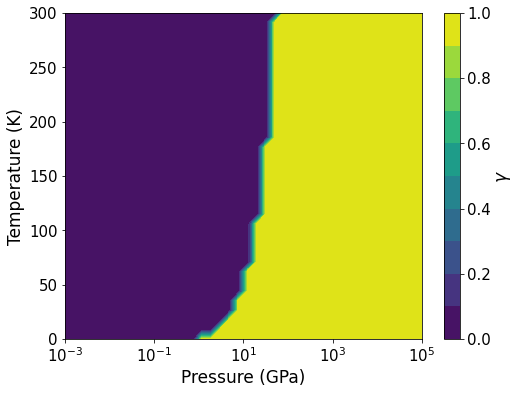

In [64]:
fig2, ax2 = plt.subplots(figsize=(8,6))

cs = ax2.contourf( pressure_list , temperature_list , outputs[1] , levels=np.linspace(0.0, 1.0, 11), vmin=0.0, vmax=1.0)
ax2.set_xscale('log')
ax2.set_xlabel('Pressure (GPa)')
ax2.set_ylabel('Temperature (K)')

# Plot actual datapoints. 
#ax2.scatter( np.broadcast_to(pressure_list, outputs[1].shape).flatten() ,  np.broadcast_to(temperature_list, outputs[1].T.shape).T.flatten(), s=3, color='red' )

cbar=fig2.colorbar(cs)
cbar.ax.set_ylabel('$\gamma$')

# Plot of the Gibbs Free Energy as a function of P and T
Purpose of this plot is simply to check that the Gibbs Free Energy changes continuously. 
Kinks are permissable, but there shouldn't be any discontinuous jumps in the Free Energy  (note, latent heat is not the same as a jump in the Free energy)

Text(0, 0.5, 'Gibbs Minimum Value (eV)')

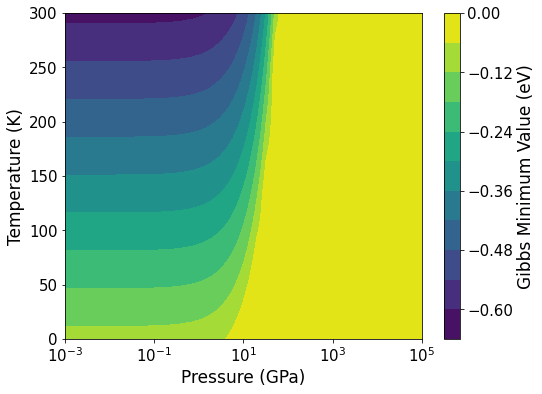

In [26]:
fig1, ax1 = plt.subplots(figsize=(8,6))

cs = ax1.contourf( pressure_list , temperature_list , outputs[0] , levels=11)
ax1.set_xscale('log')
ax1.set_xlabel('Pressure (GPa)')
ax1.set_ylabel('Temperature (K)')

# Plots the actual datapoints
#ax1.scatter( np.broadcast_to(pressure_list, Gibbs_minimum_values.shape).flatten() , np.broadcast_to(temperature_list, Gibbs_minimum_values.T.shape).T.flatten() )

cbar=fig1.colorbar(cs)
cbar.ax.set_ylabel('Gibbs Minimum Value (eV)')

# Questions:

1(a) Do the phase diagrams you have plotted make any sense at all? Can you describe, in words, why it looks the way it does?

1(b) What kind of transitions, if any, are you seeing? (e.g. 1st order, 2nd order, infinite order?)

1(c) &clubs; Is there a critical point? 

1(d) &clubs; Can you change the parameters in the function *Gibbs_Free_Energy* ,  delta_U , delta_S , and delta_V , in order to make the transition line horizontal, vertical, or to make one phase better for all temperatures and pressures? 

<h1 style="font-size: 50px">Part 2: Adding entropy of mixing</h1>


We now consider another simple system: where there are two kinds of atoms, A and B, which have different contributions to the Gibbs free energy. However, there is now also a mixing term which represents the entropy of mixing the two states. 

This could, for example, correspond to spin up atoms (A = up), and spin down atoms (B=down) in the model paramagnet. If there is a magnetic field, the spin up and spin down atoms will have different energies (different $G_A$ and $G_B$). There is also a mixing term, which corresponds to the fact there are more microstates with a mixture of up and down spins, than there are all-up, or all-down. 

$$ G_{tot} = x G_A  + (1-x)G_B + k_BT\left[x\ln(x) + (1-x)\ln(1-x)\right], $$

where $G_A$ and $G_B$ are initially treated as constants, $k_B$ is the Boltzmann constant, and $T$ is the temperature. 

## Edit the contributing terms

In [48]:
def Gibbs_Free_Energy(variables , args):
    """
    Calculates the Gibbs Free Energy for a given fraction x of atoms in state 'A' relative to total system
    
    arguments:
        x , the fraction of atoms in state A
        args , a list of all the other arguments. 
                at the moment, just temperature, but add more as needed
    
    returns:
        Gibbs Free Energy for the specific value of x. eV / mol
    """

    # Variables
    x = variables[0]
    
    # Arguments
    T = args[0] # temperature in Kelvin

      
    # Contributing terms
    G_A = 0.002  # eV/atom
    
    G_B = -0.002 # eV/atom
    
    if np.isclose(x,0.0) or np.isclose(x,1.0):
        G_mixing = 0.0
    else:
        G_mixing = Boltzmann_Constant*T*(   x*np.log(x) + (1.-x)*np.log(1.-x)  )  # eV/atom
    
    # -----------------------
    G_total = x*G_A + (1-x)*G_B + G_mixing
    
    return G_total

print('Function defined successfully!')

Function defined successfully!


# Pressure and Temperature phase diagram

The below code is designed to create diagrams of Gibbs free energy, and of the value of $x$ which minimizes the Gibbs free energy, for different values of pressure and temperature

### EDIT THIS BIT

In [28]:
pressure_list    = np.logspace(-5, 2, 15)  # creates 10 pressures between 1e-5 GPa and 100 GPa
temperature_list = np.linspace(0.0, 300, 50)  # array of 10 temperatures between 10 K and 1000 K. 


In [29]:
outputs=calculate_2_parameter_phase_diagram(pressure_list, 
                                   temperature_list,
                                   initial_values_list=[ ( 1e-8, 0.5, 1-1e-8) ],
                                   bounds_list=[(0.0,1.0)])

IntProgress(value=0, max=750)

Finished successfully!                                                                 


# Plot of $x$ as a function of P and T

Text(0, 0.5, 'x')

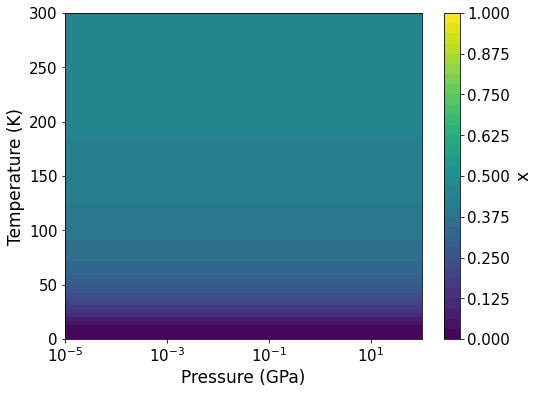

In [30]:
fig2, ax2 = plt.subplots(figsize=(8,6))

cs = ax2.contourf( pressure_list , temperature_list , outputs[1], levels=np.linspace(0.0, 1.0, 33))
ax2.set_xscale('log')
ax2.set_xlabel('Pressure (GPa)')
ax2.set_ylabel('Temperature (K)')

# Plots the actual calculated datapoints
#ax2.scatter( np.broadcast_to(pressure_list, outputs[0].shape).flatten() ,  np.broadcast_to(temperature_list, outputs[0].T.shape).T.flatten() , s=2, color='black')

cbar=fig2.colorbar(cs)
cbar.ax.set_ylabel('x')

Text(0, 0.5, '$G_{MIN}$')

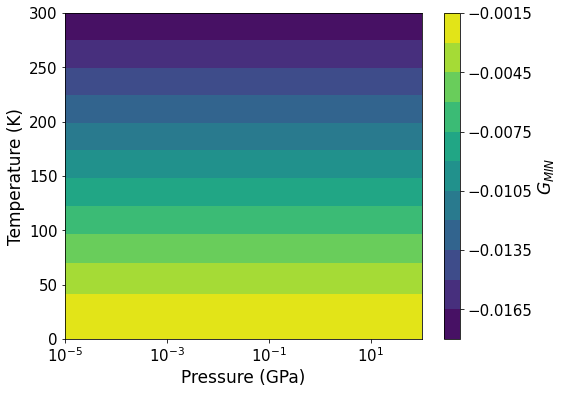

In [31]:
fig2, ax2 = plt.subplots(figsize=(8,6))

cs = ax2.contourf( pressure_list , temperature_list , outputs[0], levels=11)
ax2.set_xscale('log')
ax2.set_xlabel('Pressure (GPa)')
ax2.set_ylabel('Temperature (K)')

# Plots the actual calculated datapoints
#ax2.scatter( np.broadcast_to(pressure_list, x_minimum_values.shape).flatten() ,  np.broadcast_to(temperature_list, x_minimum_values.T.shape).T.flatten() )

cbar=fig2.colorbar(cs)
cbar.ax.set_ylabel('$G_{MIN}$')

# Questions 2:

2(a) Can you explain, in words, why the phase diagram looks the way it does given the form of $G$ ?

2(b) How, and why, do the phase diagrams differ if you change the contributing terms to $G$ to
$$ G_A = 0.005 ~ ~~~~ G_B = -0.005 ~~?$$

2(c) Does it agree with the model paramagnet?

2(d) &clubs; Can you add a term to the free energy which stops the contour lines being horizontal? 

<h1 style="font-size: 50px">Part 1 + Part 2 = Part 3</h1>

Now we write a Gibbs free energy much like that seen in part 1.

This could, for example, represent a system of atoms which have valence electrons that can be in two states: a low energy, higher entropy, but larger volume state (e.g. $s$-type orbitals)
Or they can be in a more tightly bound, greater energy, but lower volume states closer to the nucleus (e.g. $p$-type or $d$-type orbitals).

In [32]:
def Gibbs_Free_Energy(variables , args):
    """
    Calculates the Gibbs Free Energy for a given fraction x of atoms in state 'A' relative to total system
    
    arguments:
        variables : 
            x , the fraction for type A to type B
            V     , the volume of the system
    
        args , a list of other arguments. 
                at the moment, just temperature and pressure, but add more as needed
        
        settings : where delta_U , delta_S, and delta_V are set
        
    returns:
        Gibbs Free Energy for the specific value of x. eV / mol
    """
    
    # variables
    x = variables[0]
    
    # Arguments
    T=args[0]  # temperature in Kelvin
    P=args[1] 

        
    # Settings ---- EDIT THIS NUMBERS!
    delta_U = -0.04   # eV/atom
    delta_S = 0.0*Boltzmann_Constant   # eV/K/atom
    delta_V = 0.02   # A^3 / atom
    
    # Contributing terms
    G_A = 0.0
    
    G_B = ( delta_U - T*delta_S + P*delta_V ) 
    
    if np.isclose(x,0.0) or np.isclose(x,1.0):
        G_mixing = 0.0
    else:
        G_mixing = Boltzmann_Constant*T*(   x*np.log(x) + (1.-x)*np.log(1.-x)  )  # eV/atom
    
    # -----------------------
    G_total = x*G_A  +  (1. - x)*G_B  + G_mixing
    
    return G_total

print('Function defined successfully!')

Function defined successfully!


# Pressure and Temperature phase diagram

The below code is designed to create diagrams of Gibbs free energy, and of the value of $x$ which minimizes the Gibbs free energy, for different values of pressure and temperature

### EDIT THIS BIT

In [33]:
pressure_list    = np.logspace(-5, 2, 20)  # creates 10 pressures between 1e-5 GPa and 100 GPa
temperature_list = np.linspace(0.0, 300, 30)  # array of 10 temperatures between 10 K and 1000 K. 


In [34]:
outputs=calculate_2_parameter_phase_diagram(pressure_list, 
                                   temperature_list,
                                   initial_values_list=[ ( 1e-8, 0.5, 1-1e-8) ],
                                   bounds_list=[(0.0,1.0)])

IntProgress(value=0, max=600)

Finished successfully!                                                                 


# Plot of $x$ as a function of P and T

Text(0, 0.5, 'x')

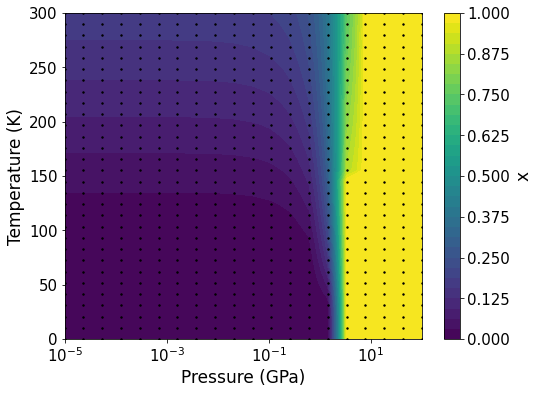

In [36]:
fig2, ax2 = plt.subplots(figsize=(8,6))

cs = ax2.contourf( pressure_list , temperature_list , outputs[1], levels=np.linspace(0.0, 1.0, 33), vmin=0.0, vmax=1.0)
ax2.set_xscale('log')
ax2.set_xlabel('Pressure (GPa)')
ax2.set_ylabel('Temperature (K)')

# Plots the actual calculated datapoints
ax2.scatter( np.broadcast_to(pressure_list, outputs[0].shape).flatten() ,  np.broadcast_to(temperature_list, outputs[0].T.shape).T.flatten() , s=2, color='black')

cbar=fig2.colorbar(cs)
cbar.ax.set_ylabel('x')

Text(0, 0.5, '$G_{MIN}$')

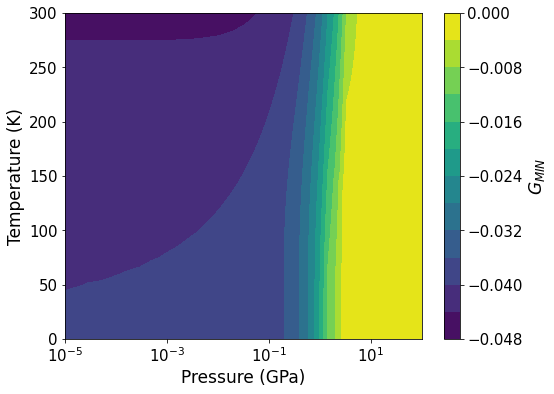

In [176]:
fig2, ax2 = plt.subplots(figsize=(8,6))

cs = ax2.contourf( pressure_list , temperature_list , outputs[0], levels=11)
ax2.set_xscale('log')
ax2.set_xlabel('Pressure (GPa)')
ax2.set_ylabel('Temperature (K)')

# Plots the actual calculated datapoints
#ax2.scatter( np.broadcast_to(pressure_list, x_minimum_values.shape).flatten() ,  np.broadcast_to(temperature_list, x_minimum_values.T.shape).T.flatten() )

cbar=fig2.colorbar(cs)
cbar.ax.set_ylabel('$G_{MIN}$')

<h1 style="font-size: 40px">Tool: Plot the Gibbs Free Energy at fixed $x$</h1>

To properly determine the order of a transition, sometimes it can be useful to plot the Free Energy with a certain fixed parameter --- e.g. the Gibbs Free energy for an (artificially) fixed $x$

The code below might be useful for this. minimize_gibbs_wrt_volume finds the smallest Gibbs Free Energy for a fixed $x$, $T$, and $P$.

### Try messing with the settings for $P$ and $T$ below. 
Does what you see make any sense?

Does it help you decide what kind of transitions are happening?

Text(0.65, 1.599999999999935e-05, 'T = 0.5 K \nP = 2.001 GPa')

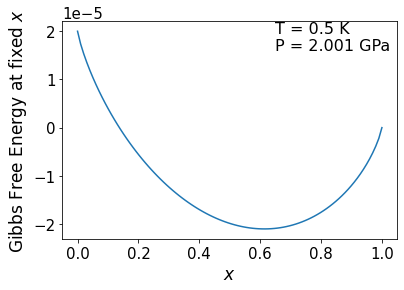

In [40]:
P = 2.001  # GPa
T = 0.5  # Kelvin

x_values = np.linspace(0.0, 1.0, 100)
G_plot_values = np.zeros(x_values.shape)

for i,x in enumerate(x_values):
    G_plot_values[i] = Gibbs_Free_Energy([x], [T,P])

plt.plot(x_values, G_plot_values)
plt.xlabel('$x$') 
plt.ylabel('Gibbs Free Energy at fixed $x$')
plt.text(0.65, np.max(G_plot_values)*0.8,'T = {} K \nP = {} GPa'.format(T,P), fontsize=16)

<h1 style="font-size: 50px">Part 4: Equations of State</h1>


## Rose-Vinet equation of state

The Rose-Vinet equation of state is an empirical equation relating volume to the Helmholtz Free Energy.

It is most commonly used in its derivative form - which just relates volume and pressure. 

However, we can imagine the two states A and B as each individually having relationships between their contribution to the free energy --- $G_A$ & $G_B$, respectively --- and the volume per atom $V$. 

The Vinet equation of state has four parameters: 
    
    E0 (a constant shift of free energy),
    
    V0 ( the volume of lowest free energy ),
    
    B0 (bulk modulus, parameterises how fast the free energy rises as the volume decreases),
    
    B_prime (a measure of how the compressibility changes as volume changes)

In [41]:
def rose_vinet_free_energy(V, E0 , V0 , B0 , B_prime):
    """
    arguments:
        E0 in eV    
        V0 in Angstrom^3 / atom
        B0 in GPa
        Bp dimensionless
    returns:
        the Helmholtz free energy from the Rose-Vinet equation of state in eV
    """
    eta = (V/V0)**(1./3.)
    B0 /= 160.21766208 # change units to eV / A^3
    
    return 4*B0*V0/(B_prime - 1.0)/(B_prime - 1.0) + 2*B0*V0/((B_prime - 1.0)*(B_prime - 1.0)) * np.exp( 1.5*(B_prime - 1.0)*(1.-eta) )  * (3*(B_prime - 1.0)*(1.-eta) - 2.)   + E0
print('Function defined successfully!')

Function defined successfully!


### Plot of Vinet eos
This shows a plot of how the Rose-Vinet equation of state relates free energy to volume for a given set of parameters. 

Try playing around with the parameters E0, V0, B0, and B_prime and see how it changes the plot. 

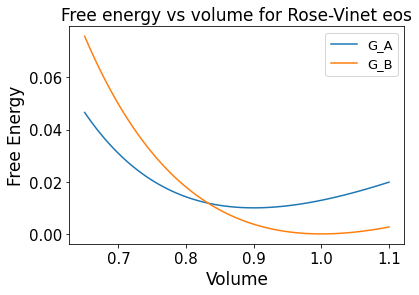

In [42]:
dummy_volumes = np.linspace(0.65, 1.1, 100)
dummy_rv_free_energy_A = rose_vinet_free_energy( dummy_volumes , E0=0.01,  V0=0.9,  B0=100.0,  B_prime=4.0)
dummy_rv_free_energy_B = rose_vinet_free_energy( dummy_volumes , E0=0.0,  V0=1.0,  B0=100.0,  B_prime=4.0)


plt.plot(dummy_volumes, dummy_rv_free_energy_A, label='G_A')
plt.plot(dummy_volumes, dummy_rv_free_energy_B, label='G_B')

plt.xlabel('Volume')
plt.ylabel('Free Energy')
plt.title('Free energy vs volume for Rose-Vinet eos')
plt.legend()

# Two phases, each with pressure and temperature dependence

We suppose we have atoms which can be in two different states, A or B, each of which has their own equation of state. 

This could be, for example, atoms which have two different ionization states: e.g. Fe$^2+$ and Fe$^3+$ in iron oxide. The different iron oxidation states have different energies and compressibilities (i.e. different equations of state). 

Or, it could be mixture of ionized atoms in a metallic liquid, or neutral atoms in a gas phase. 

$$ G_A = G_{Vinet}\left[V, E_0 = 0.0005 , V_0=0.9, B_0=100.0, B_{prime}=4.0 \right]  +  \alpha_A(\sqrt{T^2 + 1}-1) $$

$$ G_B = G_{Vinet}\left[V, E_0 = 0.0 , V_0=1.0, B_0 = 100.0, B_{prime}=4.0 \right]   +  \alpha_A(\sqrt{T^2 + 1}-1) $$

and we include the mixing term from before, and also we must include the $PV$ term:

$$ G_{total} = x*G_A + (1-x)*G_B + G_{mix} + PV $$



### EDIT THIS BIT. Edit the parameters in the equation of state

In [43]:
def Gibbs_Free_Energy( variables , args ):
    """
    Calculates the Gibbs Free Energy for a given fraction x of atoms in state 'A' relative to total system
    
    arguments:
        x , the fraction of atoms in state A
        V , the volume per atom
        args , a list of all the other arguments. 
                at the moment, just temperature, but add more as needed
    
    returns:
        Gibbs Free Energy for the specific value of x. eV / mol
    """
    
    # Variables
    x = variables[0]   # fraction of atoms in state A
    V = variables[1]   # Volume in A^3/atom
    
    # Arguments
    T = args[0]  # temperature in Kelvin
    P = args[1]  # Pressure in GPa 
    
    # Settings  --- CHANGE THESE
    E0_A = 0.01  # eV
    E0_B = 0.0   # eV
    
    #       V0 is a constant plus a temperature-dependent part, designed to mimic thermal expansion. 
    thermal_expansion_A = 5.0e-4 # Å^3/K/atom 
    thermal_expansion_B = 5.0e-4 # Å^3/K/atom
    V0_A = 0.9 +  thermal_expansion_A*(np.sqrt(T*T + 1)-1) # Å^3/atom
    V0_B = 1.0 +  thermal_expansion_B*(np.sqrt(T*T + 1)-1) # Å^3/atom
    
    B0_A = 100.0 # GPa
    B0_B = 100.0 # GPa
    
    B_prime_A = 4.0
    B_prime_B = 4.0
    
    # Contributing terms
    G_A = rose_vinet_free_energy(V, 
                                 E0=E0_A , 
                                 V0=V0_A , 
                                 B0=B0_A , 
                                 B_prime=B_prime_A)  
    
    G_B = rose_vinet_free_energy(V, 
                                 E0=E0_B , 
                                 V0=V0_B , 
                                 B0=B0_B , 
                                 B_prime=B_prime_B)  
    
    if np.isclose(x,0.0) or np.isclose(x,1.0):
        G_mixing = 0.0
    else:
        G_mixing = Boltzmann_Constant*T*(  x*np.log(x) + (1.-x)*np.log(1.-x)  )
    
    # -----------------------
    G_total = x*G_A + (1.-x)*G_B + G_mixing + P/160.21766208*V   # Note, added the PV term including conversion between GPa and eV/A^3. 
    
    return G_total
print('Function defined successfully!')

Function defined successfully!


## Pressure and Temperature phase diagram: EDIT THE RANGES

The below code is designed to create diagrams of Gibbs free energy, and of the value of $x$ which minimizes the Gibbs free energy, for different values of pressure and temperature

In [44]:
pressure_list    = np.logspace(-2, 2, 10)    # creates 10 pressures between 1e-5 GPa and 100 GPa
temperature_list = np.linspace(0.0, 100, 15)  # array of 10 temperatures between 10 K and 1000 K. 


In [45]:
outputs=calculate_2_parameter_phase_diagram(pressure_list, 
                                   temperature_list,
                                   initial_values_list=[ [1e-8, 0.5, 1-1e-8] , [0.01, 0.4, 0.8, 1.0] ],
                                   bounds_list=[(0.0,1.0), (0.0, 1e5)])

IntProgress(value=0, max=150)

Finished successfully!                                                                 


# Plot of $x$ as a function of P and T

Text(0, 0.5, 'x')

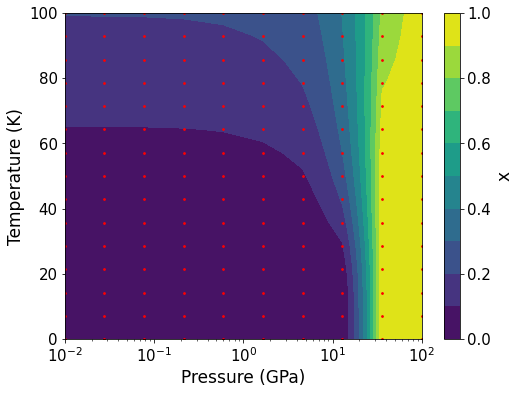

In [47]:
fig2, ax2 = plt.subplots(figsize=(8,6))

cs = ax2.contourf( pressure_list , temperature_list , outputs[1] , levels=np.linspace(0.0, 1.0, 11))
ax2.set_xscale('log')
ax2.set_xlabel('Pressure (GPa)')
ax2.set_ylabel('Temperature (K)')


# Plots the actual datapoints
ax2.scatter( np.broadcast_to(pressure_list, outputs[1].shape).flatten() , np.broadcast_to(temperature_list, outputs[1].T.shape).T.flatten(), s=3,color='red' )

cbar=fig2.colorbar(cs)
cbar.ax.set_ylabel('x')

### Plot of the volume as a function of $P$ and $T$

Text(0, 0.5, 'Volume (Å$^3$ / atom)')

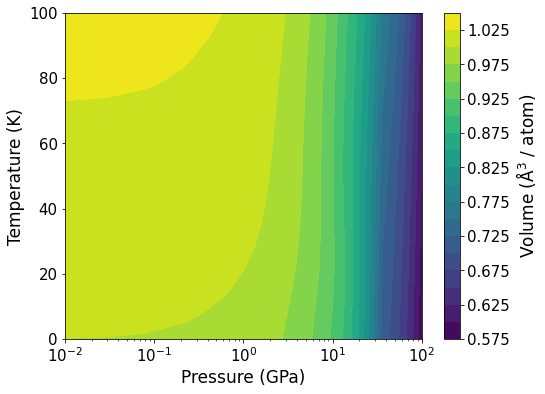

In [262]:
fig3, ax3 = plt.subplots(figsize=(8,6))

cs = ax3.contourf( pressure_list , temperature_list , outputs[2], levels=21) #, levels=np.linspace(0.0, 1.0, 21), vmin=0.0, vmax=1.0)
ax3.set_xscale('log')
ax3.set_xlabel('Pressure (GPa)')
ax3.set_ylabel('Temperature (K)')

# Plots the actual calculated datapoints
#ax3.scatter( np.broadcast_to(pressure_list, Gibbs_minimum_values.shape).flatten() ,  np.broadcast_to(temperature_list, Gibbs_minimum_values.T.shape).T.flatten(), color='red' )

cbar=fig3.colorbar(cs)
cbar.ax.set_ylabel('Volume (Å$^3$ / atom)')

# Plot of the Gibbs Free Energy as a function of P and T
Purpose of this plot is simply to check that the Gibbs Free Energy changes continuously. 
Kinks are permissable, but there shouldn't be any discontinuous jumps in the Free Energy  (note, latent heat is not the same as a jump in the Free energy)

Text(0, 0.5, 'Gibbs Minimum Value (eV)')

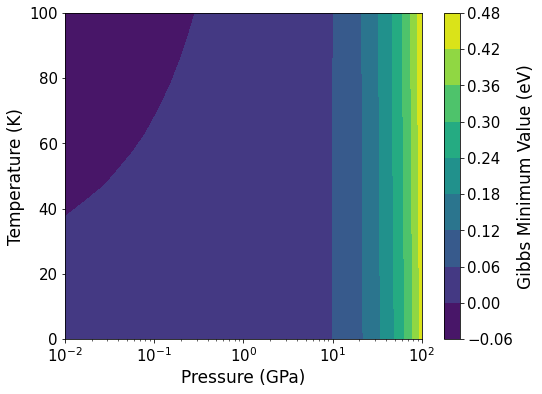

In [263]:
fig1, ax1 = plt.subplots(figsize=(8,6))

cs = ax1.contourf( pressure_list , temperature_list , outputs[0] )
ax1.set_xscale('log')
ax1.set_xlabel('Pressure (GPa)')
ax1.set_ylabel('Temperature (K)')

# Plots the actual datapoints
#ax1.scatter( np.broadcast_to(pressure_list, Gibbs_minimum_values.shape).flatten() , np.broadcast_to(temperature_list, Gibbs_minimum_values.T.shape).T.flatten(), color='red' )

cbar=fig1.colorbar(cs)
cbar.ax.set_ylabel('Gibbs Minimum Value (eV)')

<h1 style="font-size: 35px">Questions 4:</h1>

4(a). What is going on? Why does it look like this? (hint: consider the vinet equations of state plotted above)

4(b). What kind of phase transitions are there --- if any? 

4(c). How does the phase diagram change if you alter the Vinet equation of state parameters, defined in the function "Gibbs_Free_Energy"?

4(d) &clubs; Can you alter the Vinet parameters and/or the temperature and pressure ranges to plot a phase diagram with a visible critical point? 

4(e) &clubs;  Can you change the equations of state in such a way as to make the transition line below the critical point *not* vertical? 
 

<h1 style="font-size: 50px">Part 5: Adding a Liquid Phase</h1>

We add liquid phases associated with each solid. 
A melted A-type liquid, 
and a melted B-type liquid

This means we now need three parameters to minimize over:
$x$ and $y$ which quantify the proportion of A-type atoms in the solid and liquid, respectively. And $\gamma$, which quantifies the degree of melting. 

$$ x = \frac{N_A^{solid}}{N_A^{solid} + N_B^{solid}},~~~~~~~y = \frac{N_A^{liquid}}{N_A^{liquid} + N_B^{liquid}}, ~~~~~~\gamma = \frac{N_{A}^{solid} + N_B^{solid}}{N_{total}},$$


Liquid phases are typically higher energy than their solid counterparts, but also have greater entropy. Thus, we relate the contributions to the free-energy from liquid-$A$ and liquid-$B$ using four constants: $\Delta U_A$, $\Delta S_A$, $\Delta U_B$, and $\Delta S_B$, representing the change in energy and entropy between the liquid and solids, respectively. 

Final subtlety: the liquid atoms can mix with each other, and the solid atoms can mix with each other, but the solids and liquids cannot mix meaningfully. As such, the contribution to the Gibbs free energy from mixing of atoms in state A and B, $G_{mixing}$, looks slightly more complex.  

### Definition of GIbbs Free Energy: EDIT THE SETTINGS AND E-O-S in this bit

In [ ]:
def Gibbs_Free_Energy( variables , args ):
    """
    Calculates the Gibbs Free Energy for a given fraction x of atoms in state 'A' relative to total system
    
    arguments:
        variables
        x , the fraction of solid atoms in state A
        y , the fraction of liquid atoms in state B
        gamma , the fraction of atoms in solid
        V , the volume per atom
        
        args , a list of all the other arguments. 
                at the moment, just temperature, but add more as needed
    
    returns:
        Gibbs Free Energy for the specific value of x. eV / mol
    """

    # Variables
    x     = variables[0]
    y     = variables[1]
    gamma = variables[2]
    V     = variables[3]
    
    # Arguments
    T = args[0]  # temperature in Kelvin
    P = args[1]  # pressure in GPa
    
    # Settings
    delta_U_A = 0.1   # eV/atom
    delta_U_B = 0.1   # eV/atom
    delta_S_A = 100.0*Boltzmann_Constant    # eV/K/atom
    delta_S_B = 100.0*Boltzmann_Constant    # eV/K/atom
    
    # Contributing terms
    G_solid_A = rose_vinet_free_energy(V, 
                                       E0=0.0005 , 
                                       V0=0.9 , 
                                       B0=100.0 , 
                                       B_prime=4.0)
    G_liquid_A = rose_vinet_free_energy(V, 
                                        E0=0.0005 , 
                                        V0=0.9 , 
                                        B0=100.0 , 
                                        B_prime=4.0)  +  delta_U_A   - delta_S_A*T
    
    G_solid_B = rose_vinet_free_energy(V, 
                                       E0=0.0 , 
                                       V0=1.0 , 
                                       B0=100.0 , 
                                       B_prime=4.0)
    
    G_liquid_B = rose_vinet_free_energy(V, 
                                        E0=0.0 , 
                                        V0=1.0 , 
                                        B0=100.0 , 
                                        B_prime=4.0)   + delta_U_B  -delta_S_B*T
    
    
    G_mixing_A = Boltzmann_Constant*T*( (x)*np.log(x) + (1-x)*np.log(1-x) )
    G_mixing_B = Boltzmann_Constant*T*( (y)*np.log(y) + (1-y)*np.log(1-y) )
    G_mixing   = gamma*G_mixing_A + (1-gamma)*G_mixing_B
    
    # -----------------------
    G_total = gamma*x*G_solid_A + gamma*(1-x)*G_solid_B                   \
                + (1-gamma)*y*G_liquid_A + (1-gamma)*(1-y)*G_liquid_B     \
                + G_mixing + P/160.21766208*V   # Note, added the PV term including conversion between GPa and eV/A^3. 
    
    return G_total
print('Function defined successfully!')

### LEAVE THIS BIT

In [ ]:
def minimize_Gibbs(args):
    
    x_initial_values , gamma_initial_values = [0.5, 0.01, 0.99] , [0.5, 0.1, 0.9]
    V_initial_values = [ 0.1 , 0.6, 1.0 ]
    
    answer = minimize( Gibbs_Free_Energy , 
                      [0.25, 0.25, 0.25, V_initial_values[0]], 
                      args=args , 
                      tol=1e-10, 
                      bounds=[(1e-12, 1.0-1e-12), (1e-12, 1.0-1e-12), (1e-12, 1.0-1e-12), (1e-8, 1e5)])
    
    for x_init in x_initial_values :
        for gamma_init in gamma_initial_values :
            for v_init in V_initial_values :
                attempt = minimize( Gibbs_Free_Energy , 
                                   [x_init, x_init, gamma_init, v_init], 
                                   args=args, 
                                   tol=1e-10, 
                                   bounds=[(1e-12, 1.0-1e-12), (1e-12, 1.0-1e-12), (1e-12, 1.0-1e-12), (1e-8, 1e5)])
                if attempt.fun < answer.fun:
                    answer = attempt
    
    return answer
print('Function defined successfully!')

# Calculate the phase diagram

This takes a little bit longer than the previous ones --- it has several more variables to minimize over. 

In [ ]:
pressure_list    = np.logspace(-2, 4, 10)  # creates 10 pressures between 1e-5 GPa and 100 GPa
temperature_list = np.linspace(0.0, 100, 10)  # array of 10 temperatures between 10 K and 1000 K. 


### LEAVE THIS BIT

In [ ]:
# --- Makes a progress bar to track calculation of the phase diagram
max_count = len(temperature_list) * len(pressure_list)
fbar = IntProgress(min=0,max=max_count)
display(fbar)
# ---

Gibbs_minimum_values = np.zeros((len(temperature_list), len(pressure_list)))
x_minimum_values     = np.zeros((len(temperature_list), len(pressure_list)))
y_minimum_values     = np.zeros((len(temperature_list), len(pressure_list)))
gamma_minimum_values = np.zeros((len(temperature_list), len(pressure_list)))
V_minimum_values     = np.zeros((len(temperature_list), len(pressure_list)))


start = timer()
for i, T in enumerate(temperature_list):
    for j, P in enumerate(pressure_list):
        
        args = [ T, P ]
        
        answer = minimize_Gibbs( args )
        
        Gibbs_minimum_values[i,j] = answer.fun
        x_minimum_values[i,j]     = answer.x[0]
        y_minimum_values[i,j]     = answer.x[1]
        gamma_minimum_values[i,j] = answer.x[2]
        V_minimum_values[i,j]     = answer.x[3]
        
        fbar.value += 1  # increments progress bar        
        
    if i > 0:
        print("Estimated time to completion: {:.0f} s                 ".format( (timer() - start) / i * (len(temperature_list)-i)  ),  end='\r' )
print('Finished                                                      ')

# Plot of A-ness, and melt line

Melt line plotted in Red

In [ ]:
fig2, ax2 = plt.subplots(figsize=(8,6))

degree_of_A = gamma_minimum_values*x_minimum_values + (1.-gamma_minimum_values)*y_minimum_values

cs = ax2.contourf( pressure_list , temperature_list , degree_of_A , levels=np.linspace(0.0, 1.0, 11))
ax2.set_xscale('log')
ax2.set_xlabel('Pressure (GPa)')
ax2.set_ylabel('Temperature (K)')
ax2.set_title('A-type and melt line')
melt_line = ax2.contour(pressure_list, temperature_list, gamma_minimum_values, colors='red',linewidths=3, levels=[0.5])


# Plots the actual datapoints
#ax2.scatter( np.broadcast_to(pressure_list, Gibbs_minimum_values.shape).flatten() , np.broadcast_to(temperature_list, Gibbs_minimum_values.T.shape).T.flatten(), color='red', s=2 )


cbar=fig2.colorbar(cs)
cbar.ax.set_ylabel('Portion of A-type atoms')

## Plot of $\gamma$

In [ ]:
fig2, ax2 = plt.subplots(figsize=(8,6))

cs = ax2.contourf( pressure_list , temperature_list , gamma_minimum_values )
ax2.set_xscale('log')
ax2.set_xlabel('Pressure (GPa)')
ax2.set_ylabel('Temperature (K)')


# Plots the actual datapoints
#ax2.scatter( np.broadcast_to(pressure_list, Gibbs_minimum_values.shape).flatten() , np.broadcast_to(temperature_list, Gibbs_minimum_values.T.shape).T.flatten(), color='red', s=2 )

cbar=fig2.colorbar(cs)
cbar.ax.set_ylabel('$\gamma$')

## Plot of V

In [ ]:
fig2, ax2 = plt.subplots(figsize=(8,6))

cs = ax2.contourf( pressure_list , temperature_list , V_minimum_values )
ax2.set_xscale('log')
ax2.set_xlabel('Pressure (GPa)')
ax2.set_ylabel('Temperature (K)')

# Plots the actual datapoints
#ax2.scatter( np.broadcast_to(pressure_list, Gibbs_minimum_values.shape).flatten() , np.broadcast_to(temperature_list, Gibbs_minimum_values.T.shape).T.flatten(), color='red', s=2 )

cbar=fig2.colorbar(cs)
cbar.ax.set_ylabel('Volume')

<h1 style="font-size: 35px">Questions 5:</h1>

5(a). What kind of transitions are happening? Describe the phase-diagram in words. 

5(b). Is there a critical point? 

5(c). Can you manipulate the parameters defined in Gibbs_Free_Energy (both delta_U etc., and the equation-of-state parameters), in order to make the melt line not be horizontal? 

5(d). Can you make the critical point go below the melt line? 

5(e). Can you make the critical point disappear below T=0 ? 

<h1 style="font-size: 40px">Tool: Second Derivatives of the Free Energy $G(T,P)$</h1>

Second derivatives of the Free Energy are often what is measured practically in experiment. If a differentiable functional form for $G$ is known, then this can be plotted easily, but the code below calculates second derivatives numerically. 

# Isothermal compressibility
The standard thermodynamic definitions of isothermal compressibility is:
$$ \kappa_T = -\frac{1}{V}\left(\frac{\partial V}{\partial P}\right)_T = -\frac{1}{V}\left(\frac{\partial^2G}{\partial P^2}\right)_{T},  $$

In [ ]:
# List of pressures and temperatures. 
temperature = 25 # Kelvin

n_points = 100
pressure_list     = np.linspace(0.0, 5.0, n_points)
free_energy_list , volume_list , x_list  = np.zeros(n_points) , np.zeros(n_points) , np.zeros(n_points)


for i, P in enumerate(pressure_list):
    answer = minimize_Gibbs( [ temperature , P ] )
    
    free_energy_list[i] = answer.fun
    x_list[i]           = answer.x[0]
    volume_list[i]      = answer.x[1]
print('Function defined successfully!')

In [ ]:
# Create a spline interpolation of the free energy as a function of pressure. 
free_energy_interpolation  = UnivariateSpline( pressure_list , free_energy_list , k=5, s=0 )

# Differentiate the spline 
isothermal_compressibility = -1./volume_list * free_energy_interpolation.derivative(2)(pressure_list)

# Plot
plt.plot(pressure_list[5:-5] , isothermal_compressibility[5:-5])
plt.xlabel('Pressure (GPa)') , plt.ylabel('$\kappa_T$ (GPa$^-1$)')

# Isobaric Heat Capacity

The isobaric heat capacity $C_P$ is typically defined as:
$$ C_P = -T\left(\frac{\partial^2 G}{\partial T^2}\right)_P $$

In [ ]:
# List of pressures and temperatures. 
pressure = 0.8 # GPa

n_points = 100
temperature_list     = np.linspace(0.0, 100.0, n_points)
free_energy_list , volume_list , x_list  = np.zeros(n_points) , np.zeros(n_points) , np.zeros(n_points)

start = timer()
for i, T in enumerate(temperature_list):
    answer = minimize_Gibbs( [ T , pressure ] )
    
    free_energy_list[i] = answer.fun
    x_list[i]           = answer.x[0]
    volume_list[i]      = answer.x[1]
    
    if i > 0:
        print('Expected time to completion {:.0f} s         '.format((timer()-start)/i*(len(temperature_list)-i)), end='\r')
        
print('Finished                                                                             ')

In [ ]:
# Create a spline interpolation of the free energy as a function of pressure. 
free_energy_interpolation  = UnivariateSpline( temperature_list , free_energy_list , k=5, s=0 )

# Differentiate the spline 
isobaric_heat_capacity = -temperature_list * free_energy_interpolation.derivative(2)(temperature_list)

# Plot
plt.plot(temperature_list[5:-5] , isobaric_heat_capacity[5:-5])
plt.xlabel('Temperature (K)') , plt.ylabel('$C_P$ (eV / K / atom)')

<h1 style="font-size: 40px">Part 6: Challenge! Add a seperation term.</h1> 

Many substances prefer not to be perfectly mixed. Indeed, in many cases, different states would rather seperate their phases in space. In other words, mixed states have an energy penalty. 

We can model this by adding a term to the free energy from part 5:

$$ G_{seperate} = J*x*(1-x) $$

So the total free energy becomes:
$$ G_{total} = xG_A + (1-x)G_B + Jx(1-x) + G_{mix} + PV $$


The minimize_Gibbs functions function can remain the same.

6(a) Replot the phase diagrams. How does it differ? 

6(b) Can you make a critical point appear? 

6(c) What kind of phase-transitions happen (e.g. first order, 2nd order, continuous, none)?